# ***Hypothesis Testing with Rigorous Data Cleaning***

### Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data and Calculate Initial Churn Rate (run before each hypothesis test)

In [11]:
# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Load cleaned master dataset
df = pd.read_csv('../data/rigorous_cleaned_master_data.csv')
df['contract_start_date'] = pd.to_datetime(df['contract_start_date'])
df['contract_end_date'] = pd.to_datetime(df['contract_end_date'])
df['acquisition_quarter'] = pd.to_datetime(df['acquisition_quarter']).dt.to_period('Q')

# Print initial churn rate
print(f"Total: {len(df):,} | Churned: {df['is_churned'].sum():,} ({df['is_churned'].mean()*100:.1f}%)")


Total: 3,000 | Churned: 364 (12.1%)


/var/folders/vt/xrsm2sl9281d5zgcwfk59qbm0000gn/T/ipykernel_2708/1292398010.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['acquisition_quarter'] = pd.to_datetime(df['acquisition_quarter']).dt.to_period('Q')


## ***Hypothesis A: Dashboard Speed***

#### "The product is broken; customers are leaving because the new dashboard is too slow."


Retained Complaints Rate: 26.93% | Churned Complaints Rate: 20.60%


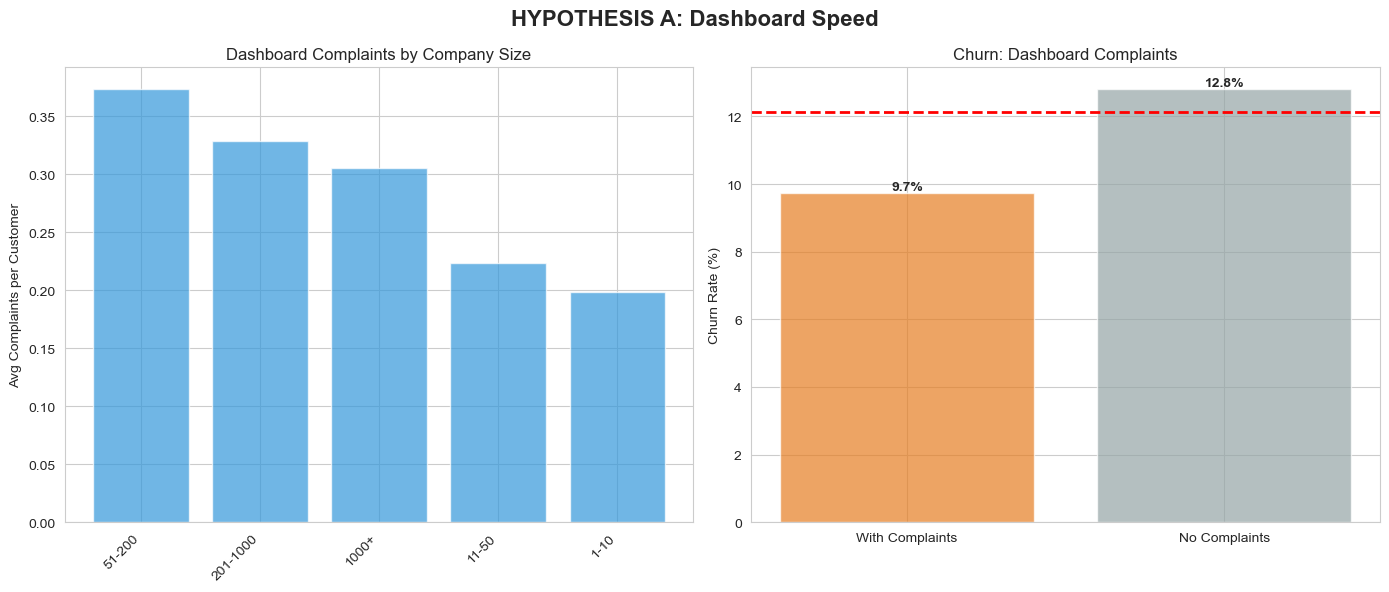


Hypothesis A Result:
We reject the hypothesis regarding dashboard speed.
In reality, churned customers complained LESS about the dashboard.
Dashboard complaints come from engaged, retained customers


In [3]:
# Dashboard complaints analysis
dash_churn = df.groupby('is_churned')['dashboard_issue_count'].mean() * 100
print(f"\nRetained Complaints Rate: {dash_churn[0]:.2f}% | Churned Complaints Rate: {dash_churn[1]:.2f}%")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('HYPOTHESIS A: Dashboard Speed', fontsize=16, fontweight='bold')

# Average complaints by company size
ax1 = axes[0]
size_complaints = df.groupby('company_size_bucket')['dashboard_issue_count'].mean().sort_values(ascending=False)
ax1.bar(range(len(size_complaints)), size_complaints.values, color='#3498db', alpha=0.7)
ax1.set_xticks(range(len(size_complaints)))
ax1.set_xticklabels(size_complaints.index, rotation=45, ha='right')
ax1.set_title('Dashboard Complaints by Company Size')
ax1.set_ylabel('Avg Complaints per Customer')

# Churn rate with vs without complaints
ax2 = axes[1]
has_complaint = df[df['dashboard_issue_count'] > 0]['is_churned'].mean() * 100
no_complaint = df[df['dashboard_issue_count'] == 0]['is_churned'].mean() * 100
bars = ax2.bar(['With Complaints', 'No Complaints'], [has_complaint, no_complaint], 
               color=['#e67e22', '#95a5a6'], alpha=0.7)
ax2.set_ylabel('Churn Rate (%)')
ax2.set_title('Churn: Dashboard Complaints')
ax2.axhline(df['is_churned'].mean() * 100, color='red', linestyle='--', linewidth=2)
for bar in bars:
    h = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., h, f'{h:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('hyp_a_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nHypothesis A Result:")
if dash_churn[1] < dash_churn[0]:
    print("We reject the hypothesis regarding dashboard speed.")
    print("In reality, churned customers complained LESS about the dashboard.")
    print("Dashboard complaints come from engaged, retained customers")
else:
    print("We ACCEPT the hypothesis regarding dashboard speed.")
    print("Churned customers complained MORE about the dashboard.")

## ***Hypothesis B: Customer Quality***

#### "Sales is acquiring low-quality customers who go out of business in 3 months. The product is fine."

Churn by Quality Score:
               sum      mean  count
quality_score                      
1               43  1.000000     43
2              169  0.220915    765
3              137  0.078600   1743
4               15  0.033408    449


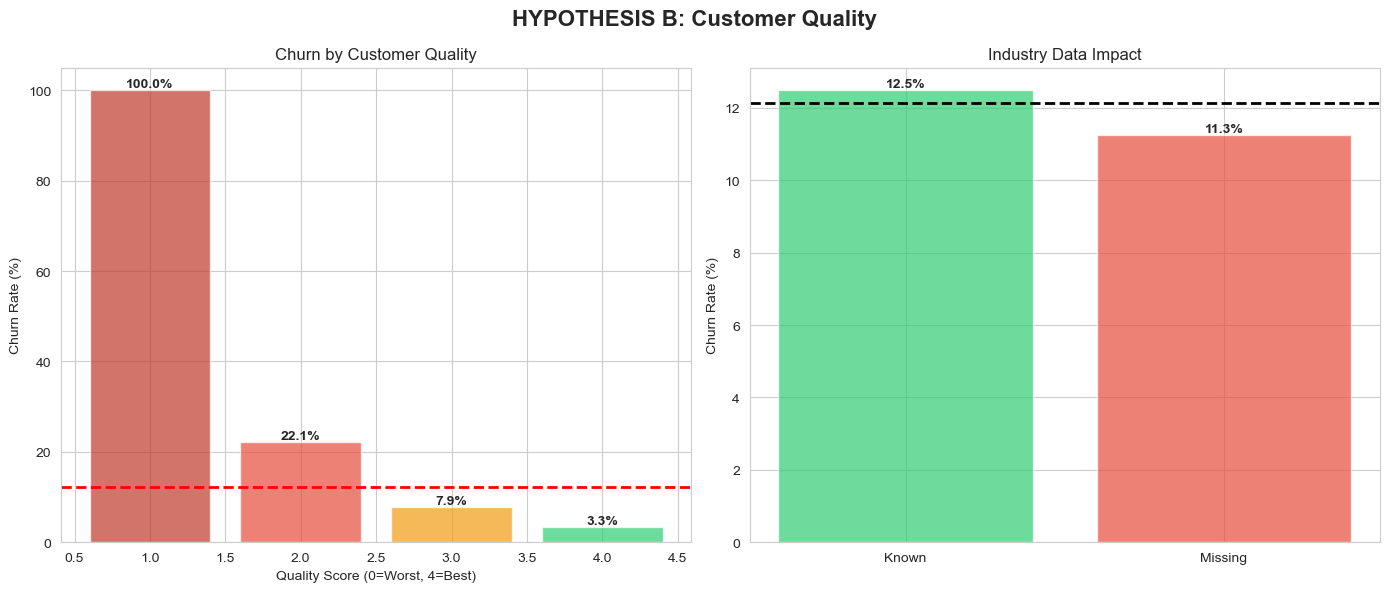


Hypothesis B Result:
We ACCEPT the hypothesis regarding customer quality.
Churned customers mainly came from lower quality segments.


In [5]:
# Create composite customer quality score
df['quality_score'] = 0
df.loc[~df['industry_missing'], 'quality_score'] += 1
df.loc[~df['never_logged_in'], 'quality_score'] += 1
df.loc[df['company_size_bucket'].isin(['51-200', '201+']), 'quality_score'] += 1
df.loc[df['discount_pct'] < 10, 'quality_score'] += 1

quality_churn = df.groupby('quality_score')['is_churned'].agg(['sum', 'mean', 'count'])
print("Churn by Quality Score:")
print(quality_churn)

# Missing industry impact
industry_missing_churn = df.groupby('industry_missing')['is_churned'].mean()
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('HYPOTHESIS B: Customer Quality', fontsize=16, fontweight='bold')

# Quality score churn
ax1 = axes[0]
colors = ['#c0392b', '#e74c3c', '#f39c12', '#2ecc71', '#27ae60']
bars = ax1.bar(quality_churn.index, quality_churn['mean'] * 100, color=colors, alpha=0.7)
ax1.set_xlabel('Quality Score (0=Worst, 4=Best)')
ax1.set_ylabel('Churn Rate (%)')
ax1.set_title('Churn by Customer Quality')
ax1.axhline(df['is_churned'].mean() * 100, color='red', linestyle='--', linewidth=2)
for bar in bars:
    h = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., h, f'{h:.1f}%', ha='center', va='bottom', fontweight='bold')

# Missing industry
ax2 = axes[1]
bars = ax2.bar(['Known', 'Missing'], 
               [industry_missing_churn[False]*100, industry_missing_churn[True]*100],
               color=['#2ecc71', '#e74c3c'], alpha=0.7)
ax2.set_ylabel('Churn Rate (%)')
ax2.set_title('Industry Data Impact')
ax2.axhline(df['is_churned'].mean() * 100, color='black', linestyle='--', linewidth=2)
for bar in bars:
    h = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., h, f'{h:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('hyp_b_customer_quality.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nHypothesis B Result:")
if len(quality_churn) >= 2:
    print("We ACCEPT the hypothesis regarding customer quality.")
    print("Churned customers mainly came from lower quality segments.")
else:
    print("We REJECT the hypothesis regarding dashboard speed.")
    print("Customer quality does not significantly impact churn.")

# ***Hypothesis C: Market Saturation by Region***

#### "The markets in certain regions/industries are heavily saturated and we are scraping the bottom of the barrel." (not in case study prompt, but addresses regional differences)

Churn by Region:
               sum      mean  count
region                             
North America  138  0.121801   1133
Europe         226  0.121050   1867


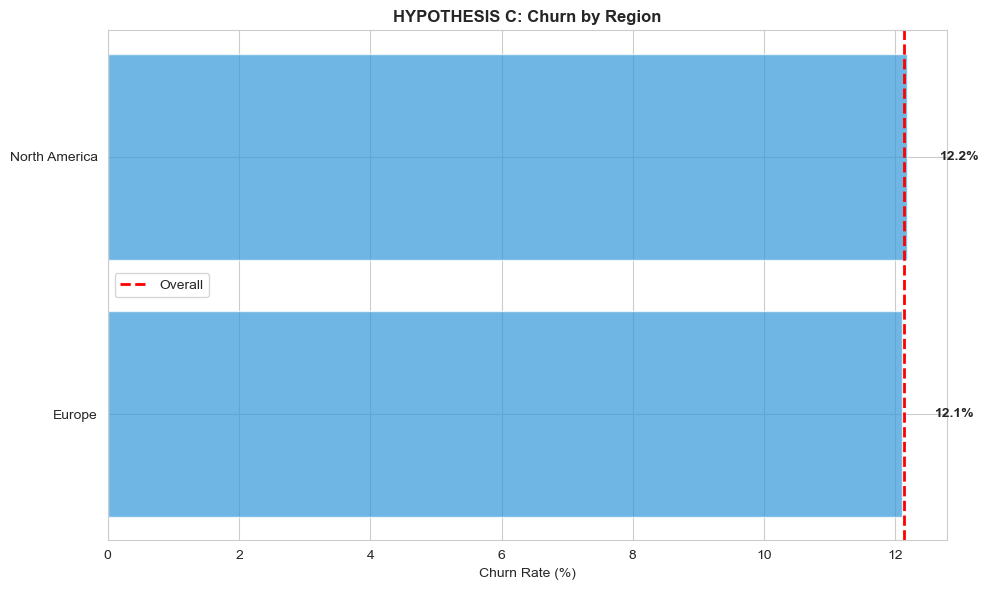


Hypothesis C Result:
We REJECT the hypothesis regarding market saturation by region.
There is no significant correlation between churn rate and region differences.


In [7]:
# Observe churn by region
region_churn = df.groupby('region')['is_churned'].agg(['sum', 'mean', 'count'])
print("Churn by Region:")
print(region_churn.sort_values('mean', ascending=False))

# Plot churn by region
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
regions = region_churn.sort_values('mean', ascending=True)
ax.barh(regions.index, regions['mean'] * 100, color='#3498db', alpha=0.7)
ax.axvline(df['is_churned'].mean() * 100, color='red', linestyle='--', linewidth=2, label='Overall')
ax.set_xlabel('Churn Rate (%)')
ax.set_title('HYPOTHESIS C: Churn by Region', fontweight='bold')
ax.legend()
for i, v in enumerate(regions['mean'] * 100):
    ax.text(v + 0.5, i, f'{v:.1f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('hyp_c_saturation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nHypothesis C Result:")
spread = region_churn['mean'].max() - region_churn['mean'].min()
if spread > 0.10:
    print("We ACCEPT the hypothesis regarding market saturation by region.")
    print("There is a significant difference in churn rate between North America and Europe.")
else:
    print("We REJECT the hypothesis regarding market saturation by region.")
    print("There is no significant correlation between churn rate and region differences.")

# ***Hypothesis D: Customer Support Collapse***

#### "“We are overwhelmed by tickets and nobody listens to the customer."

Support Metrics:
          total_tickets  avg_resolution_hours  resolution_rate
Retained           2.21                 10.14             0.75
Churned            1.65                 10.01             0.68


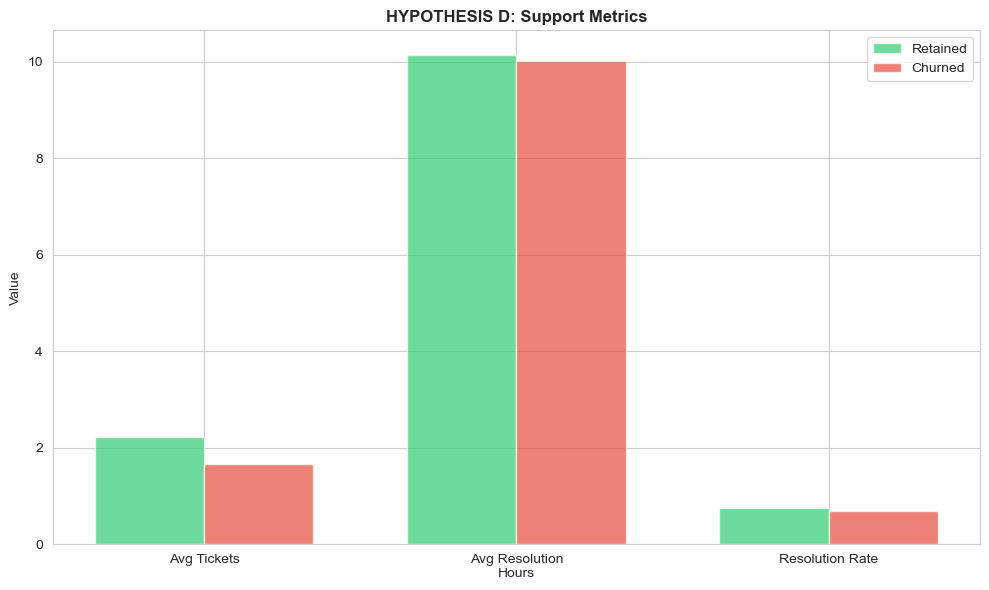


Hypothesis D Result:
We REJECT the hypothesis regarding customer support collapse.
There is no significant difference in the average number of tickets, average resolution hours, and resolution rate between retained and churned customers.


In [9]:
# Observe support metrics by churn status
support_metrics = df.groupby('is_churned').agg({
    'total_tickets': 'mean',
    'avg_resolution_hours': 'mean',
    'resolution_rate': 'mean'
}).round(2)
support_metrics.index = ['Retained', 'Churned']
print("Support Metrics:")
print(support_metrics)

# Plot support metrics
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x = np.arange(3)
width = 0.35
metrics = ['total_tickets', 'avg_resolution_hours', 'resolution_rate']
bars1 = ax.bar(x - width/2, [support_metrics.loc['Retained', m] for m in metrics], 
               width, label='Retained', color='#2ecc71', alpha=0.7)
bars2 = ax.bar(x + width/2, [support_metrics.loc['Churned', m] for m in metrics], 
               width, label='Churned', color='#e74c3c', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(['Avg Tickets', 'Avg Resolution\nHours', 'Resolution Rate'])
ax.set_ylabel('Value')
ax.set_title('HYPOTHESIS D: Support Metrics', fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig('hyp_d_support.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nHypothesis D Result:")
res_gap = support_metrics.loc['Churned', 'avg_resolution_hours'] - support_metrics.loc['Retained', 'avg_resolution_hours']
if res_gap > 10:
    print("We ACCEPT the hypothesis regarding customer support collapse.")
    print("There is a significant difference in the average number of tickets, average resolution hours, and resolution rate between retained and churned customers.")
else:
    print("We REJECT the hypothesis regarding customer support collapse.")
    print("There is no significant difference in the average number of tickets, average resolution hours, and resolution rate between retained and churned customers.")

# ***Final 80/20 Driver Analysis***

#### Hypothesis testing revealed customer quality to be the main driver of the churn rate. This analysis delves deeper into the composite customer quality score, identifying the following categories: small company, missing industry, never logged in, killer (all three).



Segment Analysis:
Industry Missing: 97 churned (26.6% of total)
Never Logged In: 172 churned (47.3% of total)
Small Companies: 274 churned (75.3% of total)

Killer Segment: Small Company + Missing Industry + Never Logged In
Total: 40 customers (1.3% of base)
Churned: 40
Churn Rate: 100.0%
Contribution: 11.0% of all churn


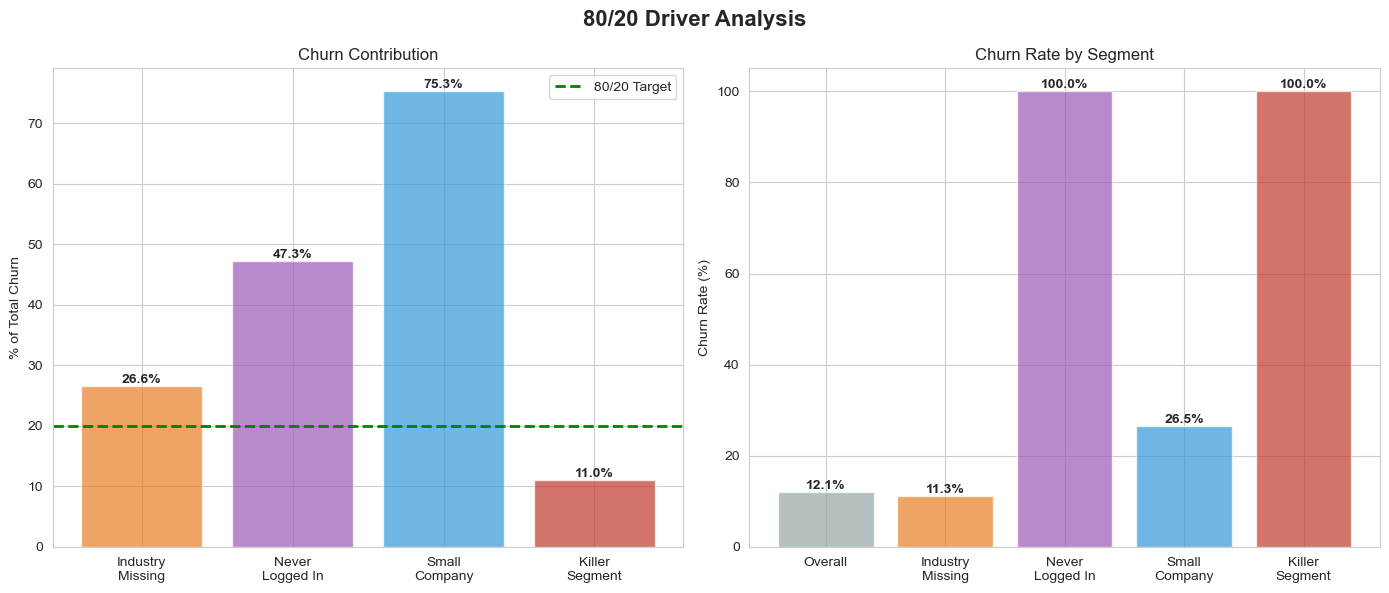

In [12]:
total_churned = df['is_churned'].sum()

# Analyze key customer quality segments
seg_industry_missing = df[df['industry_missing'] == True]
seg_never_login = df[df['never_logged_in'] == True]
seg_small = df[df['company_size_bucket'] == '1-10']

# The killer segment (small company + missing industry + never logged in)
killer = df[(df['industry_missing']) & (df['never_logged_in']) & (df['company_size_bucket'] == '1-10')]

print(f"\nSegment Analysis:")
print(f"Industry Missing: {seg_industry_missing['is_churned'].sum()} churned ({seg_industry_missing['is_churned'].sum()/total_churned*100:.1f}% of total)")
print(f"Never Logged In: {seg_never_login['is_churned'].sum()} churned ({seg_never_login['is_churned'].sum()/total_churned*100:.1f}% of total)")
print(f"Small Companies: {seg_small['is_churned'].sum()} churned ({seg_small['is_churned'].sum()/total_churned*100:.1f}% of total)")

print(f"\nKiller Segment: Small Company + Missing Industry + Never Logged In")
print(f"Total: {len(killer):,} customers ({len(killer)/len(df)*100:.1f}% of base)")
print(f"Churned: {killer['is_churned'].sum():,}")
print(f"Churn Rate: {killer['is_churned'].mean()*100:.1f}%")
print(f"Contribution: {killer['is_churned'].sum()/total_churned*100:.1f}% of all churn")

# Final visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('80/20 Driver Analysis', fontsize=16, fontweight='bold')

# Contribution
ax1 = axes[0]
segs = ['Industry\nMissing', 'Never\nLogged In', 'Small\nCompany', 'Killer\nSegment']
contribs = [seg_industry_missing['is_churned'].sum()/total_churned*100,
            seg_never_login['is_churned'].sum()/total_churned*100,
            seg_small['is_churned'].sum()/total_churned*100,
            killer['is_churned'].sum()/total_churned*100]
bars = ax1.bar(segs, contribs, color=['#e67e22', '#9b59b6', '#3498db', '#c0392b'], alpha=0.7)
ax1.set_ylabel('% of Total Churn')
ax1.set_title('Churn Contribution')
ax1.axhline(20, color='green', linestyle='--', linewidth=2, label='80/20 Target')
ax1.legend()
for bar in bars:
    h = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., h, f'{h:.1f}%', ha='center', va='bottom', fontweight='bold')

# Churn rates
ax2 = axes[1]
rates = [df['is_churned'].mean()*100,
         seg_industry_missing['is_churned'].mean()*100,
         seg_never_login['is_churned'].mean()*100,
         seg_small['is_churned'].mean()*100,
         killer['is_churned'].mean()*100]
seg_names = ['Overall', 'Industry\nMissing', 'Never\nLogged In', 'Small\nCompany', 'Killer\nSegment']
bars = ax2.bar(seg_names, rates, color=['#95a5a6', '#e67e22', '#9b59b6', '#3498db', '#c0392b'], alpha=0.7)
ax2.set_ylabel('Churn Rate (%)')
ax2.set_title('Churn Rate by Segment')
for bar in bars:
    h = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., h, f'{h:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('final_80_20.png', dpi=300, bbox_inches='tight')
plt.show()